In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

# suppress annoing warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import pandas as pd
import numpy as np

import datetime
from datetime import timedelta
# graphics settings
import matplotlib.pyplot as plt
import matplotlib as mpl
from plotnine import *

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
fullData = pd.read_csv("../data/tsData.csv")
fullData["created_at"] = pd.to_datetime(fullData["created_at"])
fullData.set_index("created_at", inplace=True)

# drop useless features in this analysis
fullData.drop(["latitude", "longitude", "weekend"], axis = 1, inplace = True)

fullData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,wind,rain
created_at,,,,,,,,,
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,2.0,0.0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,1.8,0.0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,1.7,0.0
2020-06-24 20:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,1.4,0.0
2020-06-24 21:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0


In [3]:
# set pot, and period of time where consider data
interestingPot = 1091
startDate      = datetime.datetime.strptime("2020-09-01", '%Y-%m-%d')
endDate        = datetime.datetime.strptime("2020-10-27", "%Y-%m-%d")
fd             = 7 

# train dataset
Ytrain1W = fullData.loc[fullData["pot_id"]==interestingPot][startDate:endDate]
Ytrain1W.dropna(inplace = True)

# test dataset
Ytest1W = fullData.loc[fullData["pot_id"]==interestingPot][endDate: endDate + timedelta(fd)]
Ytest1W.dropna(inplace = True)

## define target
pm2p5 = Ytrain1W["pm2p5SPS"]

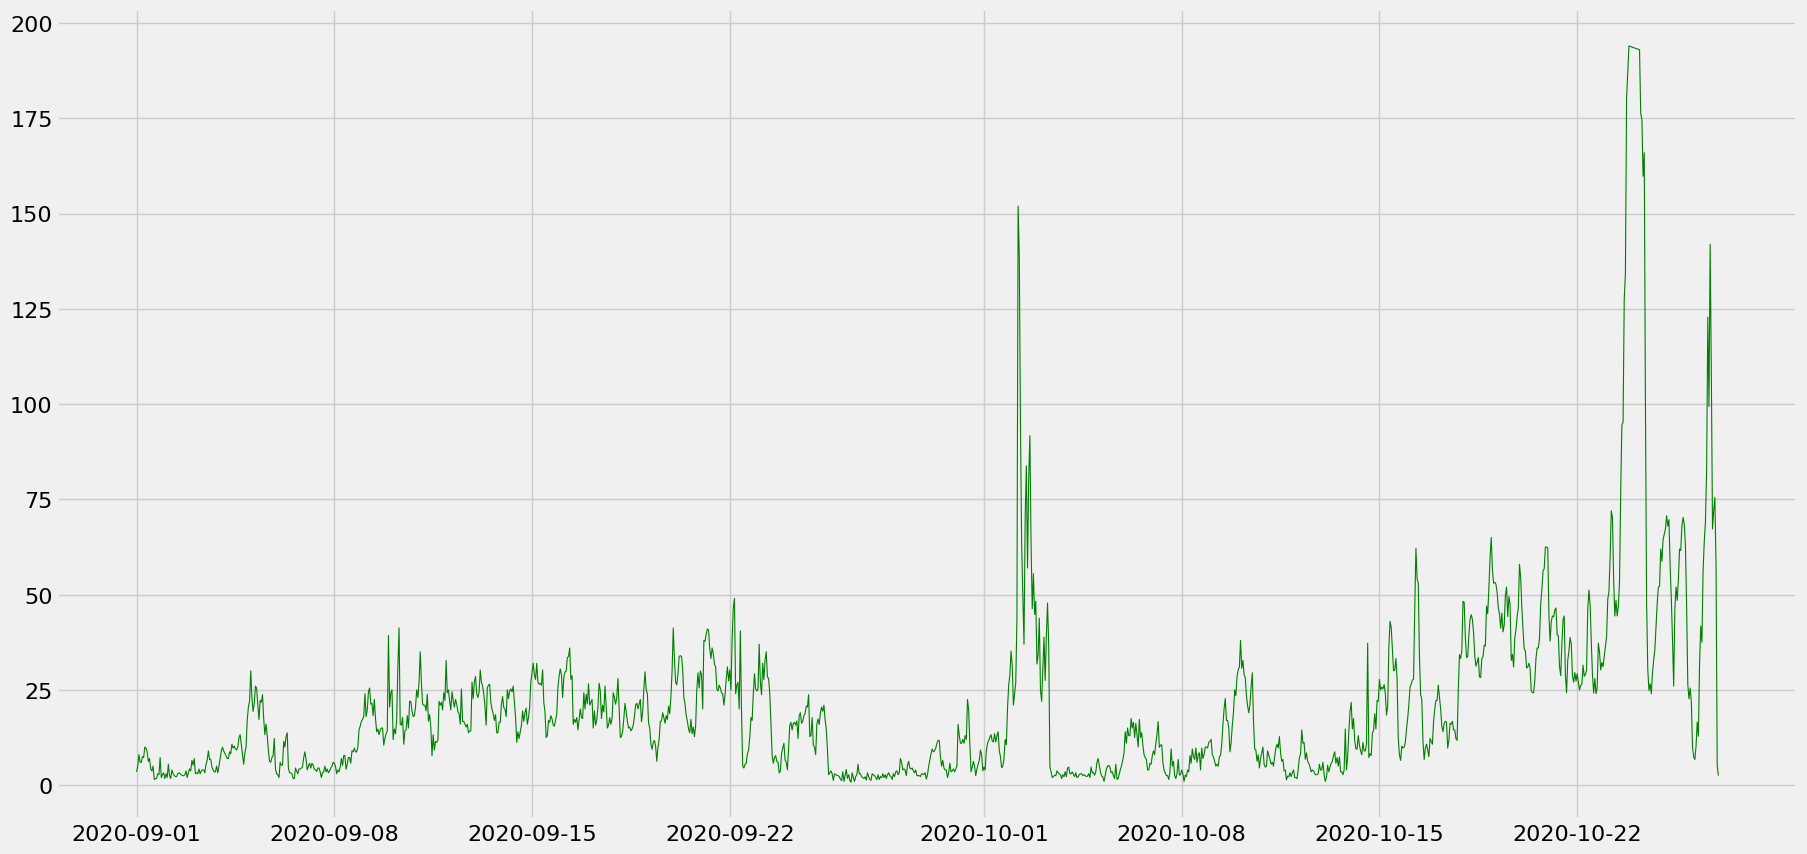

In [4]:
plt.gcf().set_size_inches(20, 10)
plt.plot(pm2p5, color="green", linewidth=0.8)
plt.show()

# Start modeling...

In [5]:
# define the model as a sum of simple model blocks
trend = tfp.sts.SemiLocalLinearTrend(observed_time_series = pm2p5)

model = tfp.sts.Sum([trend], observed_time_series = pm2p5.to_numpy())

# compute an approximation of the posterior distribution for the model
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model = model)
loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn  = model.joint_log_prob(observed_time_series = pm2p5),
    surrogate_posterior = variational_posteriors,
    optimizer           = tf.optimizers.Adam(learning_rate = 0.1),
    num_steps           = 200
)

# draw samples from the variational posterior
posterior_samples = variational_posteriors.sample(10000)

now we have sample from the posterior distribution of model parameters

In [ ]:
# how the model fits on training data??

fit = tfp.sts.one_step_predictive(
    observed_time_series = pm2p5.to_numpy(),
    model                = model,
    parameter_samples    = posterior_samples
)

In [ ]:
def plotResiduals_sts(trainData, fit, title):
    fit_mean = fit.mean().numpy()
    fit_stddev = fit.stddev().numpy()
    
    # compute standardized residuals
    res = (trainData - fit_mean)/fit_stddev

    residualsDF = pd.DataFrame({'yF' : res, 'xF' : range(res.size)})
    fittedDF    = pd.DataFrame({'yF' : fit_mean, 'xF' : range(fit_mean.size)})
    trueDF      = pd.DataFrame({'yF' : trainData, 'xF' : range(trainData.size)})

    fig, axs = plt.subplots(2,1)
    
    axs[0].scatter('xF', 'yF', data = residualsDF, color = "none", edgecolor = "blue")
    
    axs[1].plot('xF', 'yF', data = trueDF, color="black", linewidth=0.8)
    axs[1].scatter('xF', 'yF', data = fittedDF, color = "none", edgecolor = "blue")
    plt.gcf().set_size_inches(20, 15)
    fig.suptitle(title)
    plt.show()

plotResiduals_sts(pm2p5.to_numpy(), fit, "SemiLocal Linear Trend")

The model makes big error in presence of peaks...

In [ ]:
# see forecast behaviour...
forecast = tfp.sts.forecast(
    observed_time_series = pm2p5.to_numpy(),
    model                = model,
    parameter_samples    = posterior_samples,
    num_steps_forecast   = 10
)

In [ ]:
def plotForecast_sts(testData, trainData, n, forecast, title):
    fit_mean = forecast.mean().numpy()[...,0]
    fit_stddev = forecast.stddev().numpy()[..., 0]
    
    # add first element of testData to trainData for a nicer plot
    trainData.append(testData[-1:])
        
    forecastDF = pd.DataFrame({
        'yF'   : fit_mean, 
        'xF'   : range(n, fit_mean.size + n),
        'ylow' : fit_mean - 2*fit_stddev,
        'yup'  : fit_mean + 2*fit_stddev
    })
    trueDF     = pd.DataFrame({'yF' : testData, 'xF' : range(n, testData.size + n)})
    trainDF    = pd.DataFrame({'yF' : trainData[-(n+1):], 'xF' : range(n+1)})
    
    # train data
    plt.plot('xF', 'yF', data = trainDF, color = "green", linewidth = 0.8, marker = 'o')
    
    # forecast 
    plt.plot('xF', 'yF', data = forecastDF, color = "red", linewidth = 0.8, marker = 'o')
    plt.fill_between('xF', 'ylow', 'yup', data = forecastDF, facecolor = "#ff8a82", alpha = 0.2)
    
    # test data
    plt.plot('xF', 'yF', data = trueDF, color = "black", linewidth = 0.8, marker = 'o')
    plt.axvline(x = n, linestyle = "dashed", color = "orange")
    plt.gcf().set_size_inches(20, 10)
    plt.show()
    

In [ ]:
plotForecast_sts(Ytest1W['pm2p5SPS'], pm2p5, 24, forecast, "ciao")

# online learning...

In [ ]:
# get a low level description of the model
model_ssm = model.make_state_space_model(
    num_timesteps = pm2p5.to_numpy().size,
    param_vals = posterior_samples
)

In [ ]:
# get posterior distribution of latent variables at the end of the train set
# a semi local linear trend model introduces 2 latent variables, a level and a slope

# apply kalman filter until the end of the training set
pm2p5_tensor = tf.transpose(tf.Variable(np.matrix(pm2p5.values)))
_,filtered_means,filtered_covs,predicted_means,predicted_covs,_,_ = model_ssm.forward_filter(pm2p5_tensor)

# this returns a tensor of shape [num_posterior_samples, num_points, latent_size]. Each matrix obtained
# by moving along the second direction is a [num_posterior_samples, latent_size] matrix, columns are the 
# posterior samples of latent parameter at time t

In [ ]:
posterior_latent = filtered_means[:, pm2p5.to_numpy().size-1, :].numpy()

In [ ]:
plt.hist(posterior_latent[:,1], bins = 100, edgecolor = "black")
plt.gcf().set_size_inches(20, 10)
plt.title("slope posterior distribution")
plt.show()

In [ ]:
plt.hist(posterior_latent[:,0], bins = 100, edgecolor = "black")
plt.gcf().set_size_inches(20, 10)
plt.title("level posterior distribution")
plt.show()

we can use these posterior distributions as prior distribution when we recive a new datum. So to update our expectations about the future development of the series.

In [ ]:
level_mean = posterior_latent[:,0].mean()
slope_mean = posterior_latent[:,0].mean()
cov_tensor = predicted_covs[:,pm2p5.to_numpy().size-1, :].numpy()

# possible state prior??
p = tfp.distributions.MultivariateNormalFullCovariance(loc = [level_mean, slope_mean], 
                                                       covariance_matrix = cov_tensor)

In [ ]:
p.covariance()

In [ ]:
model_ssm.posterior_marginals(pm2p5_tensor)